In [1]:
import scipy.ndimage
from numpy.linalg import norm
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(100)

d = 256

s1 = 5

t = arange(- d / 2, d / 2)
h = (1 - t ** 2 / s1 ** 2) * exp(- (t ** 2) / (2 * s1 ** 2))
h = h - h.mean()

h_tf = fft.fft(fft.fftshift(h))
opA = lambda u : real(fft.ifft(fft.fft(u) * h_tf))

s = 8 # number of nonzero elements of xsharp

var = 0.2

def training_set(n):
    x_train = zeros((d, n))
    idx = random.permutation(d)
    eps_train = random.normal(0, var, (d, n))
    y_train = zeros((d, n))
    for i in range(n):
        sel = random.permutation(d)
        sel = sel[0 : s]   # indices of the nonzero elements of xsharp
        xsharp = zeros(d)
        xsharp[sel] = sign(randn(s)) * (1 - 0.3 * rand(s))

        x_train[:, i] = xsharp / np.linalg.norm(xsharp, np.inf)
        y_train[:, i] =  opA(x_train[:, i]) + eps_train[:, i]

    return x_train, y_train


N_train = 10000
x_train, y_train = training_set(N_train)  # every element is in a column

beta = abs(fft.fft(h)).max() ** 2

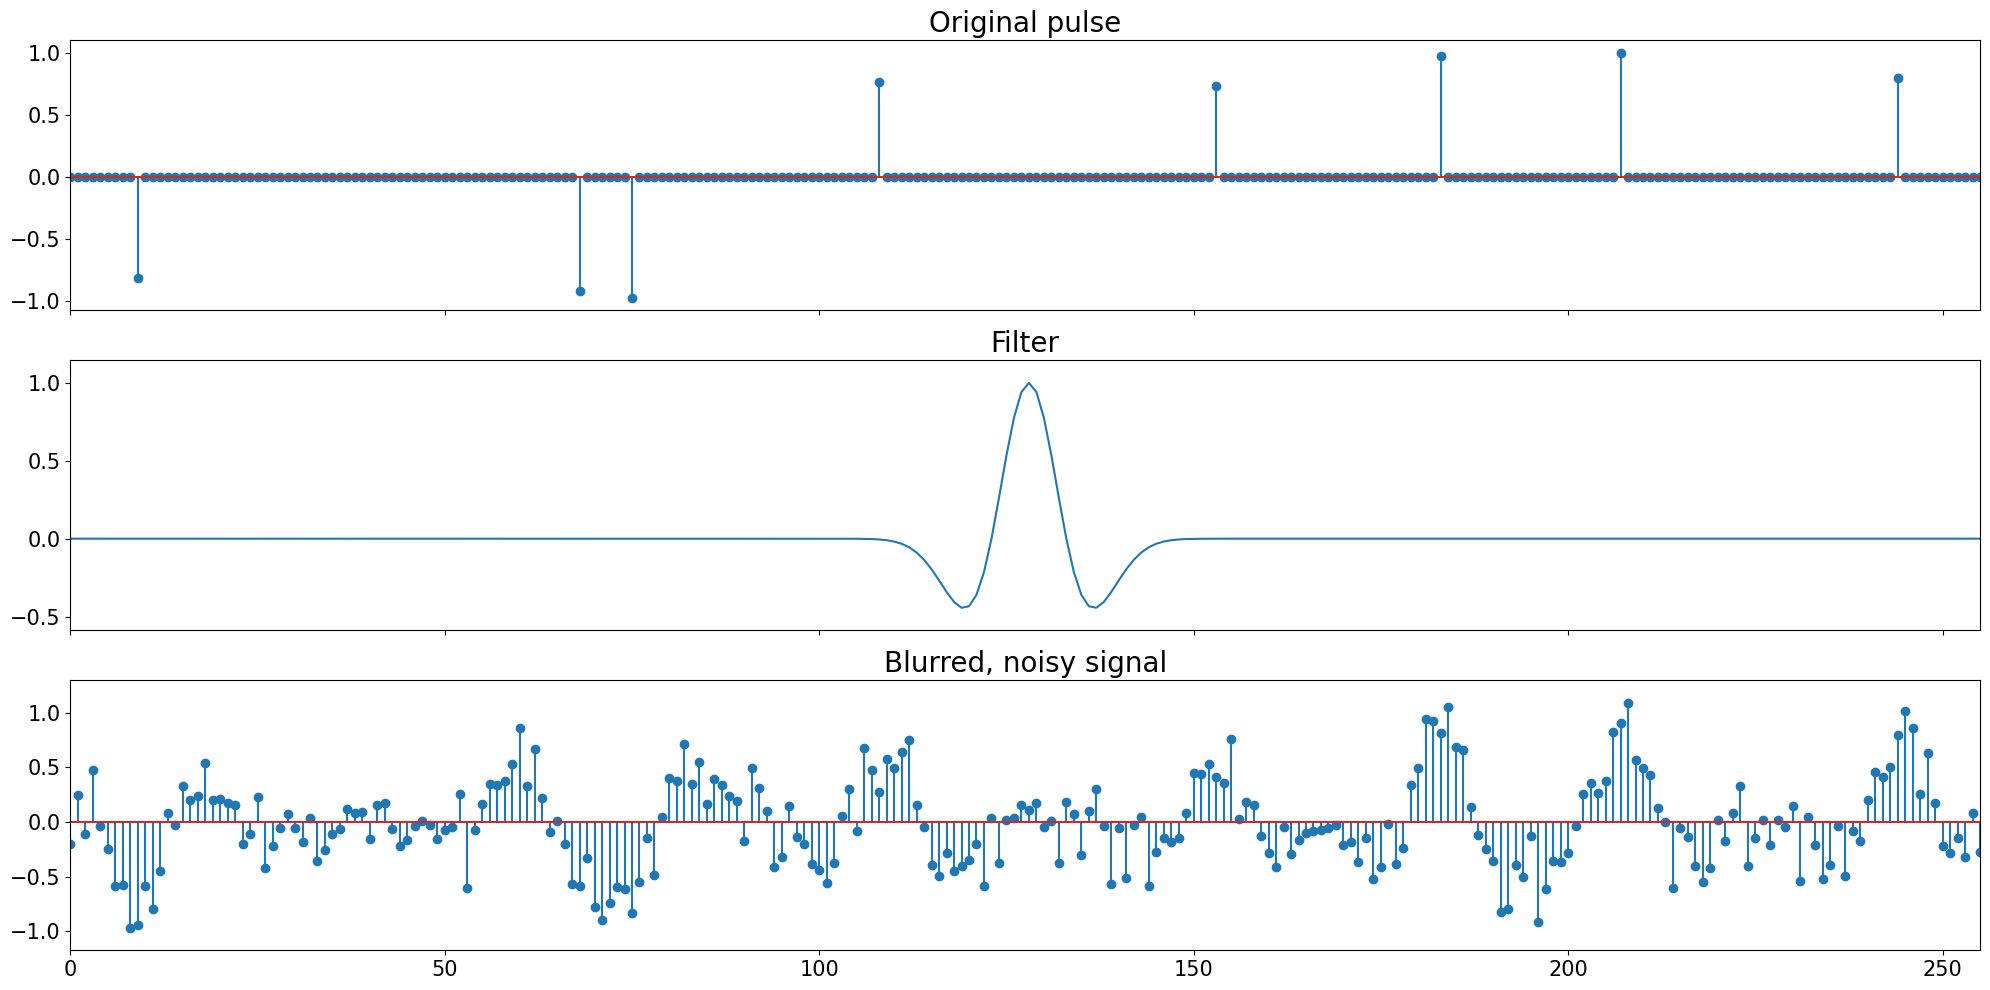

In [7]:
fig, (ax_orig, ax_win, ax_filtered) = plt.subplots(3, 1, sharex=True, figsize=(20, 10), dpi=100)
ax_orig.stem(x_train[:, 0])
ax_orig.set_title('Original pulse', fontsize=20)
ax_orig.set_xlim(0, d - 1)
ax_orig.tick_params(axis='y', labelsize=15)
ax_win.plot(h)
ax_win.set_title('Filter', fontsize=20)
ax_win.margins(0, 0.1)
ax_win.tick_params(axis='y', labelsize=15)
ax_filtered.stem(y_train[:, 0])
ax_filtered.set_title('Blurred, noisy signal', fontsize=20)
ax_filtered.margins(0, 0.1)
ax_filtered.tick_params(axis='y', labelsize=15)
plt.xticks(fontsize=15)
plt.savefig("./blurred_sparse_signal.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

In [8]:
# We compute here D_||.||_1(x, y). Inputs vectors, outputs number
def breg_dist_l1(x, y):
    return norm(x, ord=1) - dot(sign(y), x)

# soft thresholding function here:
def st(w, mu):
    w -= clip(w, -mu, mu)
    return w

def fista(y, alpha):
    max_iter = 500

    n_features = len(y)
    w = zeros(n_features)
    z = zeros(n_features)

    t_new = 1
    for _ in range(max_iter):
        t_old = t_new
        t_new = (1 + sqrt(1 + 4 * t_old ** 2)) / 2
        w_old = w.copy()
        z -= opA(opA(z) - y) / beta
        w = st(z, alpha / beta)
        z = w + (t_old - 1.) / t_new * (w - w_old)
    return w

def train_l1(la):  # lamb is a number here
    distances = zeros(N_train)
    for i in range(N_train):
        f_lasso = fista(y_train[:, i], la)
        distances[i] = breg_dist_l1(x_train[:, i], f_lasso)
    return mean(distances)


def train_l1n(n, la):  # lamb is a number here
    x_tr, y_tr = training_set(n)
    distances = zeros(n)
    for i in range(n):
        f_lasso = fista(y_tr[:, i], la)
        distances[i] = breg_dist_l1(x_tr[:, i], f_lasso)
    return mean(distances)


def cvlambda(n, lamb):  # here lambda is a vector
    l1_err = zeros(len(lamb))
    for i in range(len(lamb)):
        l1_err[i] = train_l1n(n, lamb[i])
    return l1_err.min(), lamb[argmin(l1_err)]


def get_lambda_star(lamb):  # here lambda is a vector
    l1_err = zeros(len(lamb))
    for i in range(len(lamb)):
        l1_err[i] = train_l1(lamb[i])
    return lamb[argmin(l1_err)], l1_err.min()


def get_lambda_hat(L_star, la, Nvec, iters):  # here lamb is a vector
    # Varying the number of training points
    Deltan = zeros((len(Nvec), iters))
    lamb_hatn = zeros((len(Nvec), iters))
    for i in range(len(Nvec)):
        for j in range(iters):
            lamb_hatn[i, j] = cvlambda(Nvec[i], la)[1]
            Deltan[i, j] = abs(L_star - cvlambda(Nvec[i], la)[0])
    return Deltan, lamb_hatn  # outputs two matrices

In [15]:
lamb = np.logspace(-6, 1, num=30)

lambda_star, L_lambda_star = get_lambda_star(lamb)

In [9]:
lamb = np.logspace(-6, 1, num=30)
lambda_hat = cvlambda(100, lamb)[1]

In [6]:
# We test FISTA here with la^, selected with 100 points.

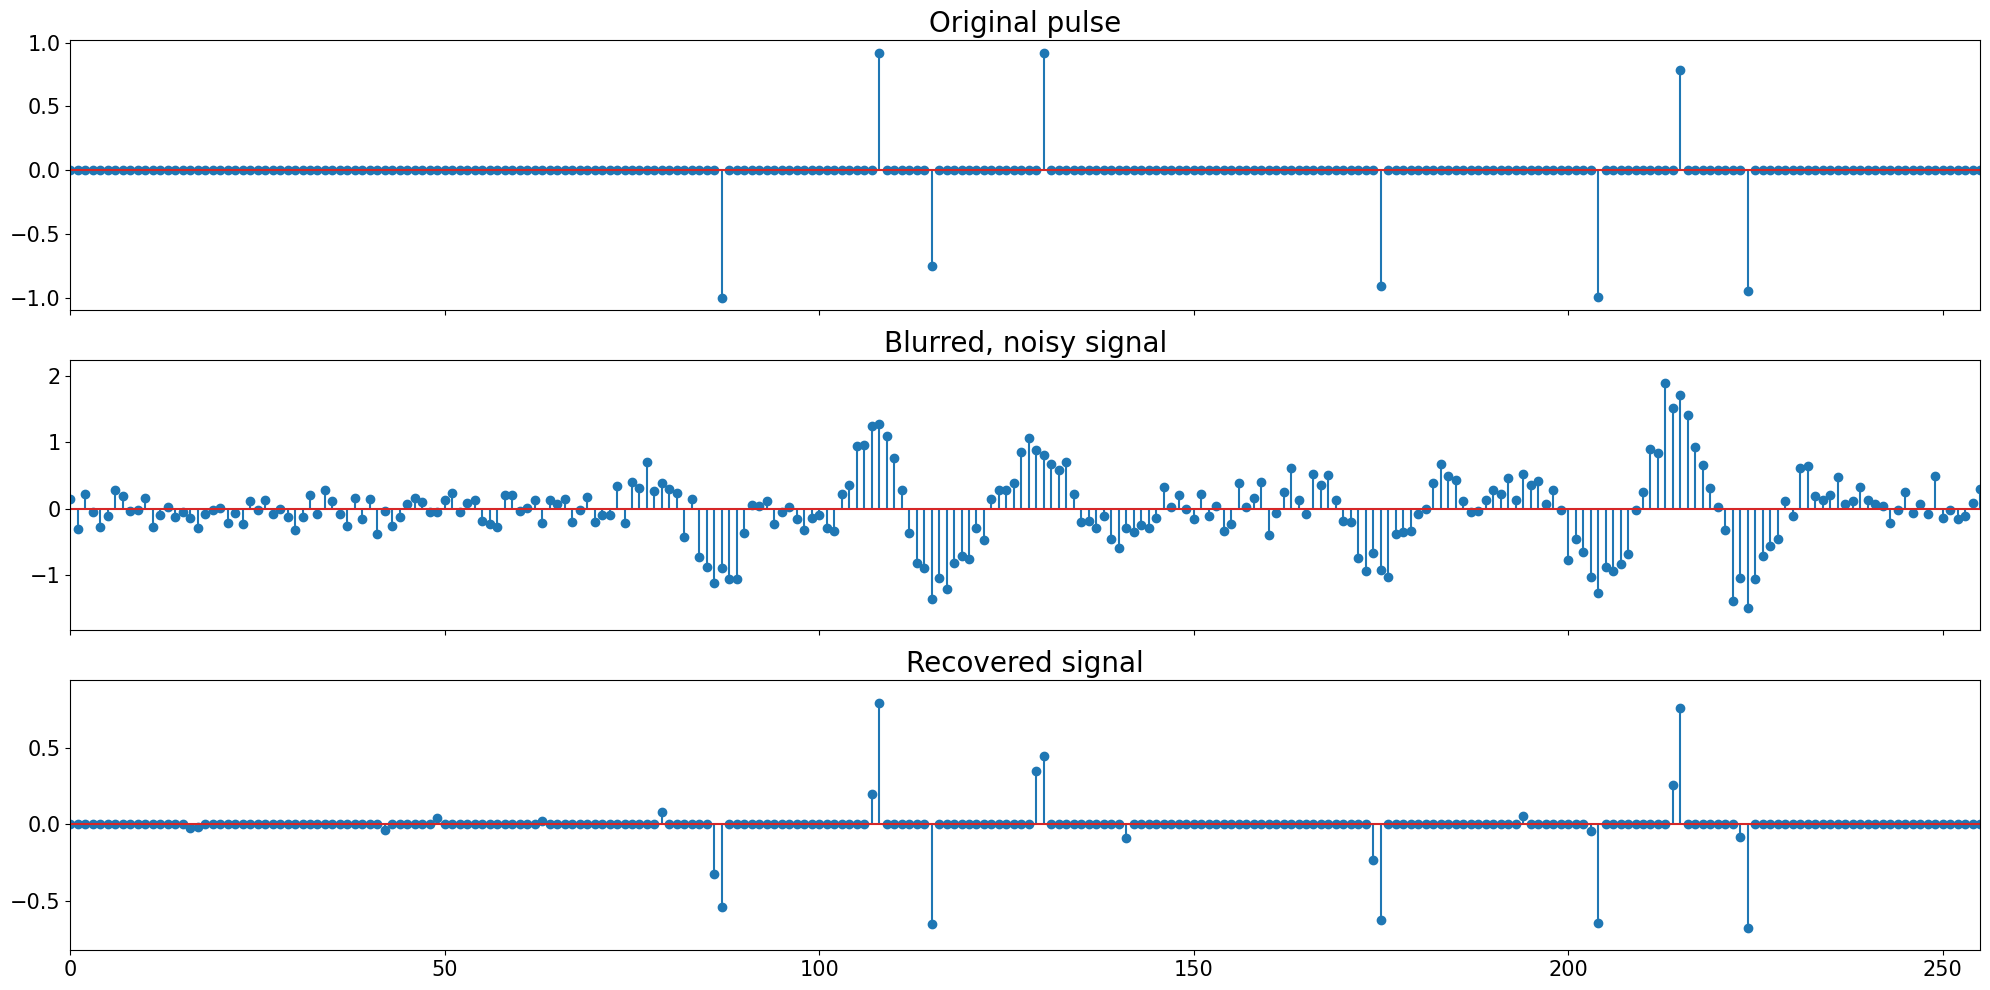

In [10]:
N_test = 10
x_test, y_test = training_set(N_test)

x = x_test[:, 0]
y = y_test[:, 0]
y_lasso = fista(y, lambda_hat)

fig, (ax_orig, ax_filtered, ax_rec) = plt.subplots(3, 1, sharex=True, figsize=(20, 10), dpi=100)
ax_orig.stem(x)
ax_orig.set_title('Original pulse', fontsize=20)
ax_orig.set_xlim(0, d - 1)
ax_orig.tick_params(axis='y', labelsize=15)
ax_filtered.stem(y)
ax_filtered.set_title('Blurred, noisy signal', fontsize=20)
ax_filtered.margins(0, 0.1)
ax_filtered.tick_params(axis='y', labelsize=15)
ax_rec.stem(y_lasso)
ax_rec.set_title('Recovered signal', fontsize=20)
ax_rec.margins(0, 0.1)
ax_rec.tick_params(axis='y', labelsize=15)
plt.xticks(fontsize=15)
plt.savefig("./sparse_deblurring.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

In [8]:
# We plot here the ER plot

In [18]:
N_vec = np.arange(10, 160, 10)
n_it = 30  # The perfect number of iterations is 30

Deltalasso = get_lambda_hat(L_lambda_star, lamb, N_vec, n_it)[0]

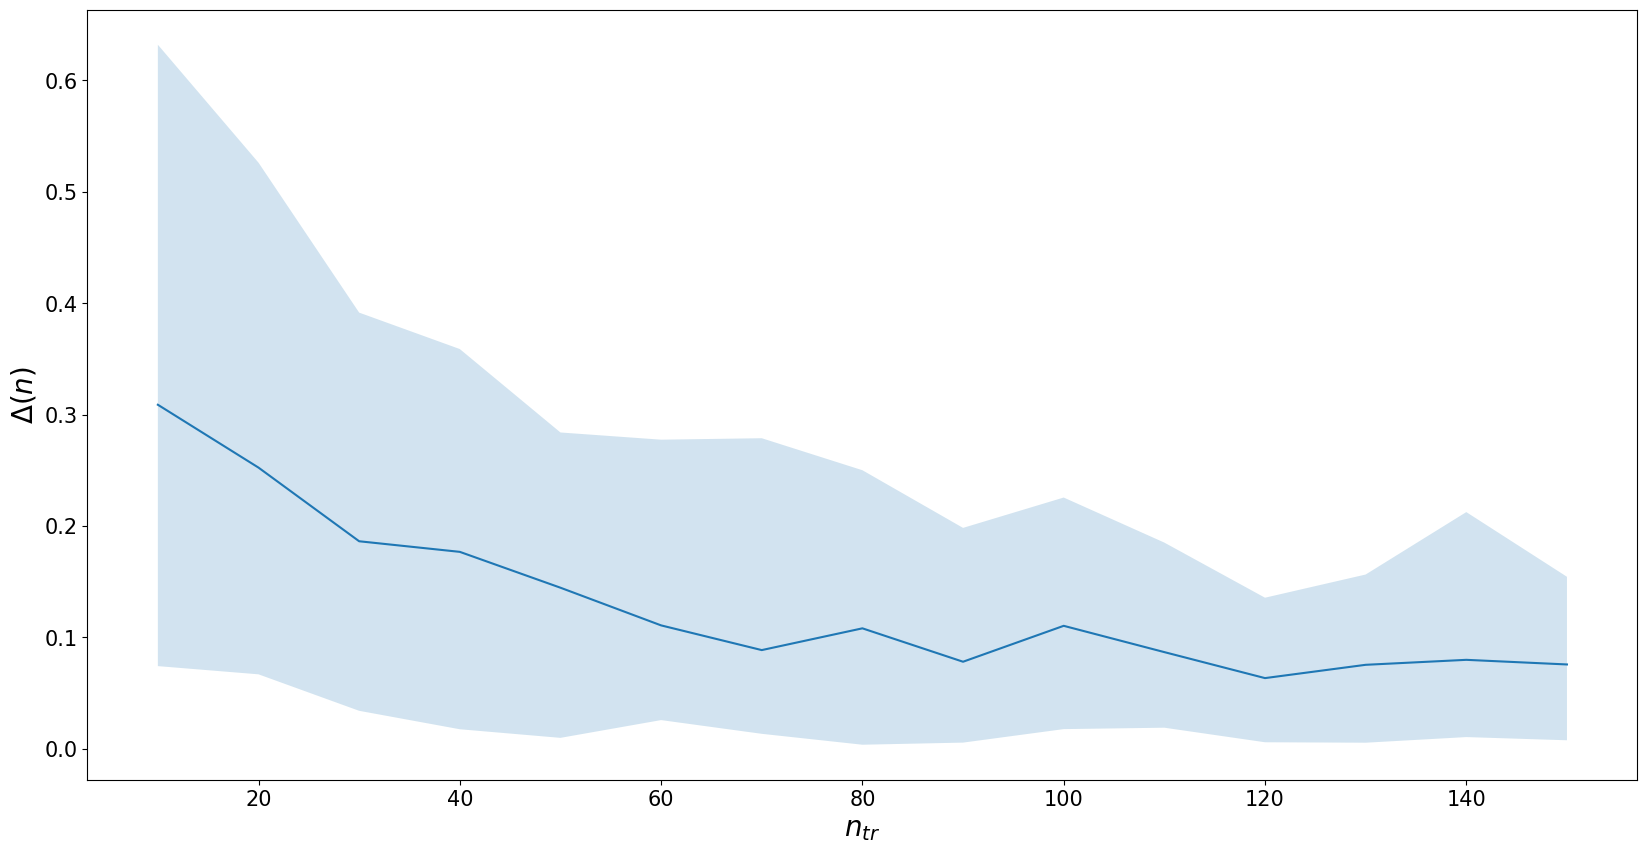

In [19]:
dflasso = pd.DataFrame(Deltalasso)
meanlasso = dflasso.mean(axis='columns')
lowerlasso = np.quantile(Deltalasso, 0.05, axis=1)
upperlasso = np.quantile(Deltalasso, 0.95, axis=1)


# Figures

plt.close('all')
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=100)
ax1.plot(N_vec, meanlasso, '-', label='Lasso')
ax1.fill_between(N_vec, lowerlasso, upperlasso, alpha=0.2)
ax1.set_ylabel(r'$\Delta(n)$', fontsize=20)
ax1.set_xlabel(r'$n_{tr}$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("./ER_lasso_deblurring.pdf", bbox_inches='tight')  # This shud go before show
plt.show(block=False)